# Test data process (xyz + uv + normal)

In [ ]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

from data_process.geometry_utils.obj import read_obj

mesh_fp = '../resources/examples/0000/0000.obj'
mesh_obj = read_obj(mesh_fp)

print('*** verts: ', mesh_obj.points.shape, mesh_obj.points.max(axis=0), mesh_obj.points.min(axis=0))
print('*** uvs: ', mesh_obj.point_data['obj:vt'].shape, mesh_obj.point_data['obj:vt'].max(axis=0), mesh_obj.point_data['obj:vt'].min(axis=0))
print('*** normals: ', mesh_obj.point_data['obj:vn'].shape, mesh_obj.point_data['obj:vn'].max(axis=0), mesh_obj.point_data['obj:vn'].min(axis=0))


## Visualize Geometry && Edges

In [ ]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 
from matplotlib.colors import to_rgb


from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#696969"},
    "木耳边": {"alias": "木耳边", "color": "#696969"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#696969"},
    "荷叶边": {"alias": "荷叶边", "color": "#696969"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd

def _draw_bboxes_2d(ax, bboxes_min, bboxes_max, color='r'):
    
    num_points = bboxes_min.shape[0]
    print(bboxes_min.shape, bboxes_max.shape, num_points)
    
    for idx in range(num_points):
        p0_ = bboxes_min[idx]
        p1_ = bboxes_max[idx]
        
        # Extract coordinates
        x0, y0 = p0_
        x1, y1 = p1_
        
        # Calculate width and height of the bounding box
        width = x1 - x0
        height = y1 - y0
        
        # Create a rectangle patch
        rect = patches.Rectangle((x0, y0), width, height, linestyle='--', linewidth=1, edgecolor=color, facecolor='none')
        
        # Add the rectangle to the plot
        ax.add_patch(rect)
    
    
data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\"
data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data['data_fp'], data['surf_cls'])
print(data['surf_wcs'].shape, data['global_offset'], data['global_scale'])
print(data['edge_wcs'].shape, data['edge_uv_wcs'].shape)

global_offset = np.array(data['global_offset'])[None]
global_scale = data['global_scale']

uv_offset = data['uv_offset'
                 ][None]
uv_scale = data['uv_scale']

########## CHECK WCS ###########
# surf_pnts = data['surf_mask'].reshape(-1, 1) * (data['surf_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset)
# edge_pnts = data['edge_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset
################################

########## CHECK NCS ###########
# Surface
bbox_scale = np.max(data['surf_bbox_wcs'][:, 3:] - data['surf_bbox_wcs'][:,:3], axis=1)[:, None, None, None]
bbox_offset = ((data['surf_bbox_wcs'][:, 3:] + data['surf_bbox_wcs'][:, :3]) * 0.5)[:, None, None, :]
surf_pnts_wcs = data['surf_mask'] * (data['surf_ncs'] * (bbox_scale * 0.5) + bbox_offset)
surf_pnts = data['surf_mask'].reshape(-1, 1) * (surf_pnts_wcs.reshape(-1, 3) * (global_scale * 0.5) + global_offset)
# Edge
edge_pnts = data['edge_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset
################################

print('*** surf_pnts: ', surf_pnts.max(axis=0), surf_pnts.min(axis=0))
print('*** edge_pnts: ', edge_pnts.max(axis=0), edge_pnts.min(axis=0))
print('*** uv_offset: ', uv_offset.shape, uv_offset.max(axis=0), uv_offset.min(axis=0))

surf_uv = data['surf_mask'].reshape(-1, 1) * (data['surf_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset)
edge_uv = data['edge_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset

surf_bbox_min = data['surf_bbox_wcs'][:, :3] * (global_scale * 0.5) + global_offset
surf_bbox_max = data['surf_bbox_wcs'][:, 3:] * (global_scale * 0.5) + global_offset

surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2] * (uv_scale * 0.5) + uv_offset
surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:] * (uv_scale * 0.5) + uv_offset

surf_color = np.random.rand(3)

print(data['surf_uv_bbox_wcs'].shape, surf_uv_bbox_min.shape, surf_uv_bbox_max.shape)

surf_colors = ((data['surf_normals'].reshape(-1, 3) + 1.0) * 0.5).clip(0, 1)
edge_colors = np.expand_dims(np.random.rand(data['edge_uv_wcs'].shape[0], 3), axis=1).repeat(data['edge_uv_wcs'].shape[1], axis=1).reshape(-1, 3)

surf_pcd = _to_o3d_pc(surf_pnts, surf_colors)
edge_pcd = _to_o3d_pc(edge_pnts, edge_colors)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.scatter(surf_uv[:, 0], surf_uv[:, 1], c=surf_colors, s=3.5)
ax.scatter(edge_uv[:, 0], edge_uv[:, 1], c=edge_colors, s=5)
ax.scatter(edge_uv[:, 0], edge_uv[:, 1], c=edge_colors, s=5)

_draw_bboxes_2d(ax, surf_uv_bbox_min, surf_uv_bbox_max, color=surf_color)

# plt.axis('off')
plt.axis('equal')
plt.show()

bboxes_3d = []
for idx in range(surf_bbox_min.shape[0]):
    bboxes_3d.append(o3d.geometry.AxisAlignedBoundingBox(surf_bbox_min[idx][..., None], surf_bbox_max[idx][..., None]))
    bboxes_3d[-1].color = to_rgb(_CMAP[_PANEL_CLS[data['surf_cls'][idx]-1]]['color'])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([surf_pcd, edge_pcd, mesh_frame] + bboxes_3d)

## Visualize Surface Points (check mask)

In [ ]:
import os
import numpy as np
import pickle
import random
from glob import glob
from matplotlib import pyplot as plt
import math

plt.rcParams['font.sans-serif']=['SimHei'] # Show Chinese label
plt.rcParams['axes.unicode_minus']=False   # These two lines need to be set manually

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']
    
data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\"
data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data['data_fp'])

num_panels = data['surf_wcs'].shape[0]

n_cols = 8
n_rows = math.ceil(num_panels / n_cols)
print(num_panels, n_cols, n_rows)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20/n_cols*n_rows))

for idx in range(num_panels):   
    # img_arr = data['surf_wcs'][idx]
    img_arr = data['surf_mask'][idx] * (data['surf_wcs'][idx] + 1.0) * 0.5
    x_idx = idx // n_cols
    y_idx = idx % n_cols     
    axs[x_idx, y_idx].set_title(_PANEL_CLS[data['surf_cls'][idx]-1])
    axs[x_idx, y_idx].imshow(np.clip(img_arr[::-1, :, :], 0., 1.).astype(np.float32))

plt.show()

## Visualize 2D Bounding Boxes

*** all_items:  100 ['E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\8426.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\7675.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\8929.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\9005.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\6433.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\7498.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\7261.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\0601.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\6307.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\9726.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\7925.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\3484.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\3052.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\7462.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\0925.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\0725.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\1319.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\4937.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\13

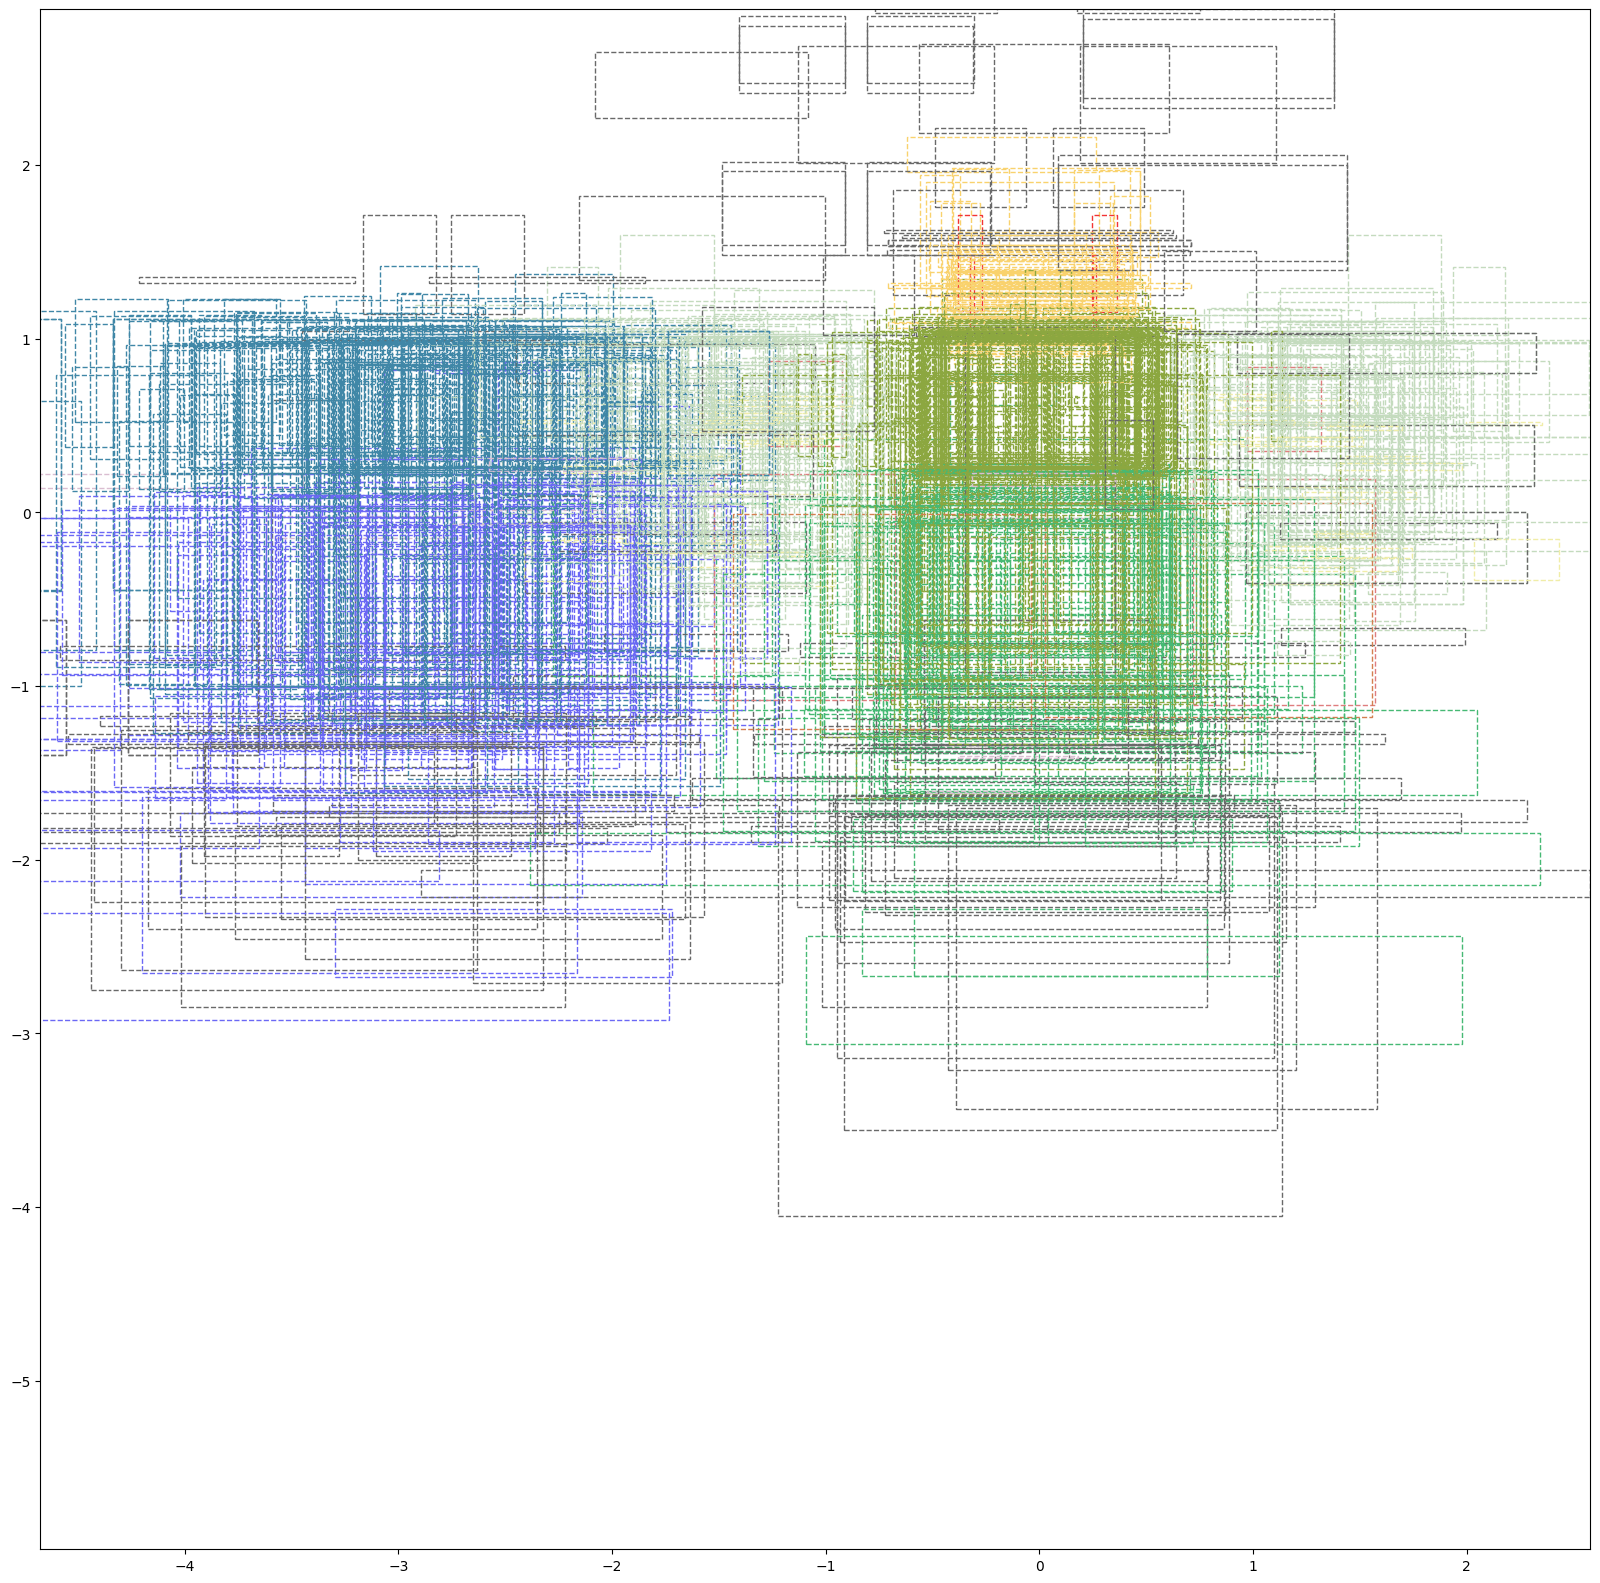

In [11]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 
from matplotlib.colors import to_rgb

from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#DACBBD"},
    "木耳边": {"alias": "木耳边", "color": "#A8D4D2"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#DACBBD"},
    "荷叶边": {"alias": "荷叶边", "color": "#A8D4D2"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']

def _draw_bboxes_2d(ax, bboxes_min, bboxes_max, color='r', cmap=None):
    num_points = bboxes_min.shape[0]
    for idx in range(num_points):
        p0_ = bboxes_min[idx]
        p1_ = bboxes_max[idx]
        
        # Extract coordinates
        
        x0, y0 = p0_
        x1, y1 = p1_
        
        # Calculate width and height of the bounding box
        width = x1 - x0
        height = y1 - y0
        # Create a rectangle patch
        rect = patches.Rectangle(
            (x0, y0), width, height, linestyle='--', linewidth=1, 
            edgecolor=color if cmap is None else cmap[idx], facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
        

data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep\\"
all_items = random.choices(glob(os.path.join(data_root, '*.pkl')), k=100)

print('*** all_items: ', len(all_items), all_items)

surf_uv_bboxes = []

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

x_min, y_min, x_max, y_max = np.inf, np.inf, -np.inf, -np.inf

for data_item in all_items:
    with open(data_item, "rb") as tf: data = pickle.load(tf)
    
    uv_scale = data['uv_scale']
    uv_offset = data['uv_offset']
    
    # print(uv_scale, uv_offset)
    
    # surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2]
    # surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:]

    surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2] * uv_scale * 0.5 + uv_offset
    surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:] * uv_scale * 0.5 + uv_offset
    
    if surf_uv_bbox_max[0].max() > x_max: x_max = surf_uv_bbox_max[0].max()
    if surf_uv_bbox_max[1].max() > y_max: y_max = surf_uv_bbox_max[1].max()
    if surf_uv_bbox_min[0].min() < x_min: x_min = surf_uv_bbox_min[0].min()
    if surf_uv_bbox_min[1].min() < y_min: y_min = surf_uv_bbox_min[1].min()
    
    surf_color = np.asarray([to_rgb(_CMAP[_PANEL_CLS[x-1]]['color']) for x in data['surf_cls']])
    _draw_bboxes_2d(ax, surf_uv_bbox_min, surf_uv_bbox_max, cmap=surf_color)    

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

## Visualize Bounding Box 3D

In [19]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 

from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#DACBBD"},
    "木耳边": {"alias": "木耳边", "color": "#A8D4D2"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#DACBBD"},
    "荷叶边": {"alias": "荷叶边", "color": "#A8D4D2"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']
        

data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\"
all_items = random.choices(glob(os.path.join(data_root, '*.pkl')), k=100)

print('*** all_items: ', len(all_items), all_items)

surf_bboxes = []

for data_item in all_items:
    with open(data_item, "rb") as tf: data = pickle.load(tf)
    
    global_scale = data['global_scale']
    global_offset = data['global_offset']
    
    # print(uv_scale, uv_offset)
    
    surf_bbox_min = data['surf_bbox_wcs'][:, :3]
    surf_bbox_max = data['surf_bbox_wcs'][:, 3:]
    
    # surf_bbox_min = data['surf_bbox_wcs'][:, :3] * global_scale * 0.5 + global_offset
    # surf_bbox_max = data['surf_bbox_wcs'][:, 3:] * global_scale * 0.5 + global_offset
    
    for idx in range(surf_bbox_min.shape[0]):
        surf_bbox = o3d.geometry.AxisAlignedBoundingBox(surf_bbox_min[idx][..., None], surf_bbox_max[idx][..., None])
        surf_bbox.color = to_rgb(_CMAP[_PANEL_CLS[data['surf_cls'][idx]-1]]['color'])
        surf_bboxes.append(surf_bbox)

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([mesh_frame] + surf_bboxes)

*** all_items:  100 ['E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\9374.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\8944.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\0982.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\3207.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\1778.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\4807.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\7510.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\8920.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\9136.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\2404.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\8584.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\10546.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\0392.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\2650.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\3216.pkl', 'E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\5857.pkl', 'E

# Validate Panel Data

  2%|▏         | 176/11027 [00:34<32:18,  5.60it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0311\阙志华\宽松V领荷叶边百褶连衣裙\pattern.json: d7a5df03-d1fc-416f-a62c-f8744252bf88 - 116
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0311\阙志华\宽松V领荷叶边百褶连衣裙\pattern.json: 05aa40da-585b-4292-8c72-0a8a03dec3d0 - 124
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0311\阙志华\宽松V领荷叶边百褶连衣裙\pattern.json: 8f20cbf6-aba0-4977-88a2-819eeadcf030 - 124
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0311\阙志华\宽松V领荷叶边百褶连衣裙\pattern.json: 7a16660b-cde3-4d43-a16f-b46219df5742 - 116


  2%|▏         | 252/11027 [00:55<28:19,  6.34it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0314\阙志华\合体一片袖衬衫袖口A摆坦克线连衣裙\pattern.json: d29b7bff-cf5e-45f0-b286-df40e57d9872 - 54
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0314\阙志华\合体一片袖衬衫袖口A摆坦克线连衣裙\pattern.json: 5ab8df68-7a0a-432d-97f0-6abe34909277 - 54


  2%|▏         | 263/11027 [00:59<1:00:15,  2.98it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0314\阙志华\宽松圆领连身袖工字褶连衣裙\pattern.json: 3488da70-e7b1-4b97-9255-f126582c6a33 - 76
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0314\阙志华\宽松圆领连身袖工字褶连衣裙\pattern.json: df996f8b-4627-415b-9b92-0a4c001ece44 - 76


  2%|▏         | 265/11027 [01:00<1:13:31,  2.44it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0314\阙志华\宽松衬衫袖口百褶连衣裙\pattern.json: 585d6c87-c498-41f8-885a-cf2f144c1749 - 73


  2%|▏         | 273/11027 [01:03<1:01:42,  2.90it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0315\张雪\吊带V字腰节线收腰太阳摆短款连衣裙\pattern.json: a22c73bc-6840-4dce-a24f-c225e3ecec0a - 48


  3%|▎         | 284/11027 [01:08<1:29:36,  2.00it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0315\张雪\吊带胸前抽褶木耳边短款连衣裙\pattern.json: a5acfb3c-f657-4996-95e2-54aec4e4b038 - 46


  3%|▎         | 315/11027 [01:14<15:45, 11.33it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0316\阙志华\合体断腰节窄肩带百褶连衣裙\pattern.json: 4b805dad-ca0d-4a85-b375-aa192c0b78f2 - 69


  3%|▎         | 374/11027 [01:21<1:06:57,  2.65it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0319\张雪\娃娃领前胸打褶泡泡短袖段腰节裙摆单褶木耳边合体连衣裙\pattern.json: 38127611-2659-4875-913d-cbb938e73c38 - 116


  4%|▎         | 412/11027 [01:30<33:20,  5.31it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0319\阙志华\合体压褶木耳边一片袖连衣裙\pattern.json: 76d0bdbf-fa06-4cf3-8f18-4f14fca2cfe9 - 142


  4%|▍         | 418/11027 [01:32<1:15:52,  2.33it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0319\阙志华\合体木耳边一片袖连衣裙\pattern.json: 4c1cac94-edf2-42be-a52c-5e3e7d4e14e1 - 63
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0319\阙志华\合体木耳边一片袖连衣裙\pattern.json: 057ec93a-97e0-4d03-b1d7-63edf7d23338 - 63


  4%|▍         | 424/11027 [01:35<1:19:54,  2.21it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0319\阙志华\合体衬衫领百褶半开襟连衣裙\pattern.json: fbb8c414-bc20-4650-bff4-8facbf70f28b - 63
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0319\阙志华\合体衬衫领百褶半开襟连衣裙\pattern.json: ca64298a-7432-4de5-a59d-efad06ca2154 - 63


  4%|▍         | 454/11027 [01:43<46:17,  3.81it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0320\张雪\领口木耳边泡泡长袖高腰宽松短款连衣裙\pattern.json: 1a699d68-b354-4bba-952e-1d321093153a - 44


  5%|▌         | 580/11027 [02:13<19:06,  9.11it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0322\阙志华\合体V领顺褶拼腰节无袖连衣裙\pattern.json: 6e013f67-1d37-416d-a80a-a223da88be7f - 56
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0322\阙志华\合体断腰节坦克线荷叶边连衣裙\pattern.json: a0928816-1f29-40c1-8163-9508172be541 - 80
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0322\阙志华\合体断腰节坦克线荷叶边连衣裙\pattern.json: ee57590f-558d-41f9-8b74-43de785ac2ea - 80
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0322\阙志华\合体断腰节坦克线荷叶边连衣裙\pattern.json: 9b1d1846-9673-4041-805c-f9c42f86a009 - 88
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0322\阙志华\合体断腰节坦克线荷叶边连衣裙\pattern.json: 88f7accb-e11d-40d2-afb3-5eb81b47e940 - 88


  7%|▋         | 797/11027 [02:48<06:52, 24.80it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0328\张晓雯\合体腰侧抽皱宽肩带木耳边连衣裙\pattern.json: d6514171-c471-4aa4-90d3-5382438bf7c2 - 83
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0328\张晓雯\合体腰侧抽皱宽肩带木耳边连衣裙\pattern.json: 983c3ec5-f1ba-417b-b578-477b8f746ac9 - 83


  7%|▋         | 814/11027 [02:49<10:57, 15.54it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0328\张雪\运动小翻领短袖H型运动连衣裙\pattern.json: 82333398-ac78-46a9-89dc-fa3a2a3f9436 - 版片226_1_1_1_2_1
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0328\林春秀\百褶裙\pattern.json: 19941d69-6c91-4ea8-a659-47305eb8de9d - 46
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0328\林春秀\百褶裙\pattern.json: 94004e77-221b-4e1d-8ac9-2c1dc17a6cf3 - 46


  8%|▊         | 830/11027 [02:51<18:33,  9.16it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0328\阙志华\合体衬衫领风琴褶短袖断腰节叠门襟连衣裙\pattern.json: 7c27bb9f-984f-413d-b85b-0216775e16ac - 52
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0328\阙志华\合体衬衫领风琴褶短袖断腰节叠门襟连衣裙\pattern.json: 0d2a8112-3e1e-48b5-85c1-36a4ef9898cb - 52


  8%|▊         | 841/11027 [02:56<1:28:34,  1.92it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0329\张晓雯\合体收腰翻领短袖刀背缝连衣裙\pattern.json: 8a87db94-a659-4530-b538-13ff00c1966b - 41


  8%|▊         | 897/11027 [03:07<1:43:20,  1.63it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q1\objs\参考图+工程类\0304\林春秀\修身宽领口插肩短袖侧开衩\修身宽领口插肩短袖侧开衩\pattern.json: 872d779e-047d-41e4-9864-d6aa92e0e976 - arm_1_2 Symmetry 1


  8%|▊         | 903/11027 [03:09<1:06:16,  2.55it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q1\objs\参考图+工程类\0304\林春秀\紧身后V领无袖侧抽褶长裙\紧身后V领无袖侧抽褶长裙\pattern.json: 95029350-2311-4b21-96fe-d1dea1201574 - 版片19


  8%|▊         | 905/11027 [03:11<1:32:50,  1.82it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\参考图+工程类\0305\李青秀\修身衬衫领泡泡袖连衣裙\修身衬衫领泡泡袖连衣裙\pattern.json: 08f4cce2-40bf-4880-9c50-c4c09fb6cb97 - 43
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\参考图+工程类\0305\李青秀\修身衬衫领泡泡袖连衣裙\修身衬衫领泡泡袖连衣裙\pattern.json: 7f1dfa62-b28f-407b-b66b-ce41fa6ff546 - 43


  9%|▊         | 946/11027 [03:17<24:24,  6.89it/s]  

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q1\objs\参考图+工程类\0306\林春秀\A型V领荷叶泡泡袖短袖中长裙\A型V领荷叶泡泡袖短袖中长裙\pattern.json: 223ead9b-71a1-4ce5-a96a-17df7d09467e - 版片13 对称 1
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q1\objs\参考图+工程类\0306\林春秀\A型V领荷叶泡泡袖短袖中长裙\A型V领荷叶泡泡袖短袖中长裙\pattern.json: cf674333-0e02-4e7a-a779-e8245d450e69 - arm_1
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q1\objs\参考图+工程类\0306\林春秀\A型V领荷叶泡泡袖短袖中长裙\A型V领荷叶泡泡袖短袖中长裙\pattern.json: 9603fe50-5df7-46a9-b7e8-b3b04f170562 - 版片15_2 对称 1
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q1\objs\参考图+工程类\0306\林春秀\A型V领荷叶泡泡袖短袖中长裙\A型V领荷叶泡泡袖短袖中长裙\pattern.json: 764a43c4-86d9-440f-9c5a-503152304f70 - 版片15_2


 10%|▉         | 1087/11027 [03:57<35:58,  4.60it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\参考图+工程类\0314\卓刚军\紧身连身立领一片长袖收腰下打褶中长裙\紧身连身立领一片长袖收腰下打褶中长裙\pattern.json: b15dc72f-515f-43ab-9fc1-48116d066281 - 43
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q1\objs\参考图+工程类\0314\卓刚军\紧身连身立领一片长袖收腰下打褶中长裙\紧身连身立领一片长袖收腰下打褶中长裙\pattern.json: 3d1e1ef5-f937-4be5-8a94-e004eec3d99c - 43


 11%|█         | 1225/11027 [04:33<05:37, 29.00it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0407\张晓雯\宽松断腰节大翻领泡泡袖连衣裙\pattern.json: be4f572c-53de-471d-b681-b80146ccd5ee - 109
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0407\张晓雯\宽松断腰节大翻领泡泡袖连衣裙\pattern.json: a07e93aa-a049-4d3e-a9f4-4866f1f24d2e - 110


 11%|█▏        | 1248/11027 [04:35<12:24, 13.14it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0407\张雪\娃娃领泡泡袖直筒低腰百褶短款针织连衣裙\pattern.json: 59dbbabf-aaa5-4da2-b02c-ddad94320a41 - 92
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0407\张雪\娃娃领泡泡袖直筒低腰百褶短款针织连衣裙\pattern.json: ed7068c2-c546-43c7-ac45-76df35ab5ee5 - 92


 12%|█▏        | 1272/11027 [04:39<18:06,  8.98it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0407\张雪\百褶翻领灯笼袖牛筋腰节收腰连衣裙\pattern.json: ab1d6798-8d19-47b7-8f41-409822049932 - 102
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0407\张雪\百褶翻领灯笼袖牛筋腰节收腰连衣裙\pattern.json: 89da3930-d5d4-4123-aa6d-dad9eb1eea5a - 102


 13%|█▎        | 1453/11027 [05:25<25:46,  6.19it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0408\于芮煌\合体无袖宽肩带\pattern.json: f7bbfa89-fc2a-4acf-8c95-36276e1b7daa - 42


 14%|█▍        | 1537/11027 [05:45<23:01,  6.87it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0409\林春秀\T恤连衣裙-54风琴褶\pattern.json: c5f46196-4b6e-44ae-b9c3-92aa4fa8f42a - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0409\林春秀\T恤连衣裙-54风琴褶\pattern.json: 207c22c6-5ad3-452f-82d5-e9e9f42d1d08 - 246


 15%|█▍        | 1651/11027 [06:02<15:28, 10.09it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0411\张雪\大翻领灯笼袖叠门襟断腰节百褶下摆连衣裙\pattern.json: b0d48c36-e660-404d-b7a4-8221722bc4be - 55
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0411\张雪\大翻领灯笼袖叠门襟断腰节百褶下摆连衣裙\pattern.json: 7d6ee894-5c1a-4b3b-91ec-76fc3f1ad6c4 - 58


 16%|█▋        | 1792/11027 [06:22<06:56, 22.16it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0415\阙志华\修身彼得潘领一片袖抽褶连衣裙\pattern.json: cf6ecbbc-25c8-4f6a-9948-c02c64205363 - 106


 17%|█▋        | 1852/11027 [06:28<15:46,  9.69it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0416\阙志华\V领合体喇叭型短袖抽褶连衣裙\pattern.json: f5a2e7ea-c6f0-4589-8605-a807007b3e0f - 52


 17%|█▋        | 1867/11027 [06:29<09:03, 16.86it/s]

[TOO_MANY_PANELS] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0417\于芮煌\修身圆领一片袖拼腰节A摆百褶\pattern.json: 61


 18%|█▊        | 1973/11027 [06:41<10:14, 14.73it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0418\张晓雯\合体方领断腰节下摆打褶连衣裙\pattern.json: 5f501183-d87b-47de-b7af-ff108eb9d4f2 - 42


 18%|█▊        | 1980/11027 [06:42<07:12, 20.94it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0418\张雪\V领8分一片袖正常肩胸前单褶拼腰节上下平下摆拼接抽褶合体连衣裙\pattern.json: e9ba9d63-de0d-49c8-91e0-b40ca29a8df2 - 46


 18%|█▊        | 2036/11027 [06:46<10:29, 14.29it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0418\阙志华\亨利领露肩长袖宽松拼腰节抽褶荷叶边连衣裙\pattern.json: c180f7d6-f12b-40a5-83fb-10aa2ff7502c - 42


 19%|█▊        | 2053/11027 [06:47<16:22,  9.13it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0419\张晓雯\合体方领木耳边A摆连衣裙\pattern.json: 4c0e35ca-31ea-4748-8db8-2f71101c8533 - 83
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0419\张晓雯\合体方领木耳边A摆连衣裙\pattern.json: b084e15d-9fab-4490-adc1-ffbcc2715a09 - 83


 19%|█▊        | 2067/11027 [06:51<27:10,  5.49it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0419\张雪\吊带荷叶边方领收腰右侧缝抽褶紧身针织连衣裙\pattern.json: e237ea3d-3fd5-44d9-9728-163b50472c10 - 83
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0419\张雪\吊带荷叶边方领收腰右侧缝抽褶紧身针织连衣裙\pattern.json: 46e0862b-510d-40ce-b23c-9dc1eb2a34b2 - 83


 19%|█▉        | 2136/11027 [06:54<03:20, 44.33it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0422\于芮煌\修身圆领一片袖A摆百褶\pattern.json: e7740f30-8983-4997-8595-6f8a64ed316d - 56
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0422\于芮煌\修身圆领一片袖A摆百褶\pattern.json: ac0bd17c-39e2-4154-85cf-df1ecb6ccb9d - 82


 20%|█▉        | 2164/11027 [06:55<04:24, 33.52it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0422\张雪\立领叠门襟落肩拐袖拼腰节收腰腰上下抽褶下摆多层次短款宽松连衣裙\pattern.json: 186ae6e2-5ac7-478d-8a4d-f4fb75e9f0b7 - 群前中
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0422\张雪\立领叠门襟落肩拐袖拼腰节收腰腰上下抽褶下摆多层次短款宽松连衣裙\pattern.json: 4d3ef5ed-1234-4eaf-9476-ad91fedb17ae - 群前中
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0422\张雪\立领叠门襟落肩拐袖拼腰节收腰腰上下抽褶下摆多层次短款宽松连衣裙\pattern.json: f5a15d80-af61-4421-a1d5-bd0e54369903 - 群前中
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0422\张雪\罗纹圆领落肩拐袖收腰上腰抽褶下平下摆A型长款连衣裙\pattern.json: 85784ad8-f49f-4c43-8473-6d464074777a - 版片116 拷贝 1_1
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0422\张雪\罗纹圆领落肩拐袖收腰上腰抽褶下平下摆A型长款连衣裙\pattern.json: 84e6ad4e-2b0d-4cab-a57f-0ef463046906 - 版片116


 20%|█▉        | 2175/11027 [06:55<04:46, 30.86it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0422\张雪\衬衫领叠门襟落肩拐袖袖山袖口抽褶牛筋腰节左右不对称左抽牛筋右荷叶边收腰短款宽松连衣裙\pattern.json: 48e7be22-08da-4707-85e0-d6f881d2bfcf - 版片56 拷贝 1_2
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0422\张雪\衬衫领叠门襟落肩拐袖袖山袖口抽褶牛筋腰节左右不对称左抽牛筋右荷叶边收腰短款宽松连衣裙\pattern.json: 01651028-c0ba-4caa-a585-d6af95dbd191 - 版片56


 21%|██        | 2280/11027 [07:05<04:38, 31.44it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\于芮煌\合体海军领叠门襟A摆木耳边\pattern.json: f07544d6-9535-4336-b9c8-d1454397cb40 - 93


 21%|██        | 2294/11027 [07:06<08:24, 17.30it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节宽肩风琴褶下裙有领衬衫领尖领半门襟无袖\pattern.json: 20487a81-7274-4678-9481-898919c91689 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节宽肩风琴褶下裙有领衬衫领尖领半门襟无袖\pattern.json: 3b322e1b-5ae7-4f69-918c-fafaa219bac3 - 246


 21%|██        | 2303/11027 [07:08<17:46,  8.18it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟无袖\pattern.json: bcddbcec-60c6-4a4a-85a4-619db5f6a1cb - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟无袖\pattern.json: 0c5de10b-e050-4a81-ba7a-1e51dbd47840 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖一片袖\pattern.json: d497c053-d2a5-4808-9fba-4a7d75ece979 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖一片袖\pattern.json: c0081e8f-c3fb-471f-a022-923b89c6684d - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖两片袖\pattern.json: 306de3e4-de03-44eb-88c7-a1e00d9ed556 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖两片袖\pattern.json: 404be0e1-eff6-46d1-b886-8779a2c01b49 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\

 21%|██        | 2308/11027 [07:08<11:46, 12.35it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖缺角袖\pattern.json: 6469d726-8d7b-4def-a39e-0903b4333347 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖缺角袖\pattern.json: 6742e723-3dc1-4278-986d-df2a4524f8d2 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节窄肩风琴褶下裙有领衬衫领尖领半门襟无袖\pattern.json: 51bc9416-34a0-45f8-9394-a1bfc685e724 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0424\林春秀\H型收腰省断腰节窄肩风琴褶下裙有领衬衫领尖领半门襟无袖\pattern.json: 9f7c0636-9184-4bc8-9a78-8657bbbeb905 - 246


 21%|██▏       | 2368/11027 [07:17<19:42,  7.32it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖层叠袖\pattern.json: 9b407f0f-1a4c-450b-9525-014a4b67a972 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖层叠袖\pattern.json: 7ffc75a1-3b49-40aa-811f-0907a7de96a4 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖手帕袖\pattern.json: 334f49d6-cab2-4008-9490-ccd7eeef497a - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖手帕袖\pattern.json: 75774d24-019c-47d3-acd3-007566849081 - 246


 21%|██▏       | 2370/11027 [07:17<20:02,  7.20it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖气球袖\pattern.json: d1beaae7-6dfc-4849-a7a8-a1208eb6b6f4 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖气球袖\pattern.json: da1d4699-69bb-4b5f-9bbe-b3df98283a93 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖泡泡袖\pattern.json: 168c82e4-8565-4542-8eba-ca7a9261ebc0 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖泡泡袖\pattern.json: 809a79f5-edd0-4e2c-84e2-ebf1bf99b57d - 246


 22%|██▏       | 2371/11027 [07:17<21:36,  6.68it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖灯笼袖\pattern.json: 200fb2c2-3507-404a-b931-5fa86289e537 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖灯笼袖\pattern.json: 41803b82-3b72-4b96-9f56-3ebc408f6f53 - 246


 22%|██▏       | 2373/11027 [07:18<27:18,  5.28it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖蝴蝶袖\pattern.json: 138bae40-7662-473b-90fe-86aa54bf7a9a - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟短袖蝴蝶袖\pattern.json: 4350aac7-f0de-4033-8369-7c4c6f422dfc - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖喇叭袖口\pattern.json: c35397ed-9f14-4872-becd-9896b36530ae - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖喇叭袖口\pattern.json: e61a1228-c8d5-4e7c-93b3-6133ecf7f847 - 246


 22%|██▏       | 2375/11027 [07:18<22:09,  6.51it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖抽褶袖口\pattern.json: d4e9a3ab-22c1-445d-a3b6-62893977ff9e - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖抽褶袖口\pattern.json: e3c9cef8-3ea8-43b9-a7b4-c984727ff776 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖木耳袖口\pattern.json: cbb8dcd1-4b1e-4d25-be20-0fc9416e1ad4 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖木耳袖口\pattern.json: d5999c42-4716-4955-b020-e3dbc9c236b5 - 246


 22%|██▏       | 2376/11027 [07:18<28:14,  5.11it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖淑女袖\pattern.json: 6df43934-f160-4074-a395-731c0c4b8ed6 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖淑女袖\pattern.json: ac909db3-d81f-41c7-8c79-2b475bfaa1eb - 246


 22%|██▏       | 2377/11027 [07:19<39:29,  3.65it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖漏斗袖\pattern.json: 10cd1d1c-c0bb-40eb-8325-4f08bfdabcd0 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖漏斗袖\pattern.json: a082d838-8861-4b86-89d3-021d82e0efeb - 246


 22%|██▏       | 2378/11027 [07:19<57:58,  2.49it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖羊腿袖\pattern.json: 3cc9e363-9b43-401d-9c17-2cc70922853a - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖羊腿袖\pattern.json: 8d7bcf42-b350-4970-a233-243d4f708fb1 - 246


 22%|██▏       | 2379/11027 [07:20<50:26,  2.86it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖荷叶边\pattern.json: 6d5bc2f5-8fac-444e-89d4-a07402d7349a - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖荷叶边\pattern.json: 56157353-9fd6-4222-997c-f4416dfd72a8 - 246


 22%|██▏       | 2380/11027 [07:20<1:07:40,  2.13it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖藕节袖\pattern.json: 703d2dce-b2a3-4e8d-9863-a72b440eb672 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖藕节袖\pattern.json: 5dbb0679-94cb-41d8-829e-5b29be9a5151 - 246


 22%|██▏       | 2381/11027 [07:21<1:04:54,  2.22it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖衬衫袖口\pattern.json: ccbf911a-e96e-467a-a5b1-6548eefb9351 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖衬衫袖口\pattern.json: 04d8c21f-5275-42bb-acb8-04ce691981fc - 246


 22%|██▏       | 2382/11027 [07:21<1:09:29,  2.07it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖袖山抽皱泡泡袖\pattern.json: 8820993f-c26a-4fe3-b3cf-8abb54697c59 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖袖山抽皱泡泡袖\pattern.json: 3444a530-cd33-4b1e-a2a3-38abe5644ab3 - 246


 22%|██▏       | 2383/11027 [07:22<1:13:32,  1.96it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖露肩袖\pattern.json: e12225ae-ae80-4f2c-bcbb-ee7a319ed467 - 246
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\林春秀\H型收腰省断腰节正常肩风琴褶下裙有领衬衫领尖领半门襟长袖露肩袖\pattern.json: 193cc639-8ce4-4bf8-8b63-013d4c43d5a6 - 246


 22%|██▏       | 2401/11027 [07:29<24:25,  5.88it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\阙志华\百褶收腰V领短袖X型连衣裙\pattern.json: 788571a5-3f63-4814-a59c-382fa3f9d046 - 53
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0425\阙志华\百褶收腰V领短袖X型连衣裙\pattern.json: fdc7f078-e9bb-40e0-a428-fad6d867dc59 - 53


 22%|██▏       | 2480/11027 [07:41<19:09,  7.44it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0426\阙志华\V领连袖公主线断腰节下摆A形百褶连衣裙\pattern.json: c7c81f14-6953-432b-a854-da6d2efca9cf - 86
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0426\阙志华\V领连袖公主线断腰节下摆A形百褶连衣裙\pattern.json: 3f5e5809-dbeb-492c-ac1f-88b8e321d3dd - 86
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0426\阙志华\交叉门襟连袖公主线断腰节下摆A形百褶连衣裙\pattern.json: 1e4a31f7-d022-4ce6-923c-0e66ba30acb6 - 86
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0426\阙志华\交叉门襟连袖公主线断腰节下摆A形百褶连衣裙\pattern.json: 52fb0d42-5aa7-4f65-b13e-7c9ae1b50d69 - 86


 23%|██▎       | 2496/11027 [07:44<33:38,  4.23it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0426\阙志华\翻领半叠门襟连袖公主线断腰节下摆百褶A形连衣裙\pattern.json: fef66e99-f5c2-4ef4-87b7-970dea919825 - 86
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0426\阙志华\翻领半叠门襟连袖公主线断腰节下摆百褶A形连衣裙\pattern.json: 9f8027fc-8dd9-4c67-b8ef-0499dfe3f8d4 - 86


 24%|██▎       | 2615/11027 [08:16<33:47,  4.15it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0429\张雪\圆领短袖下摆百褶宽松连衣裙\pattern.json: 39ce5709-7902-47a4-a3e2-e35053dd8be8 - 51
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0429\张雪\圆领短袖下摆百褶宽松连衣裙\pattern.json: 3ee498de-bdd0-4765-9d44-d7e817b798b7 - 49


 25%|██▍       | 2702/11027 [08:33<39:08,  3.54it/s]  

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0430\张晓雯\H型正常肩无袖无门襟袖窿公主线分割单向褶荷叶摆无领高垂领\pattern.json: 0e3a4bd7-952c-4353-897a-05dd9543877d - 荷叶摆


 29%|██▊       | 3145/11027 [09:56<59:40,  2.20it/s]  

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0508\肖晓珊\H型1正常肩1-无袖1半开门襟1收腰省1抽皱腰节1拼接抽皱1有领-海军领2\pattern.json: c91340de-c017-4a8a-846f-59b86f17336e - 原型连衣裙木耳边领.领.S


 29%|██▊       | 3155/11027 [09:57<12:56, 10.13it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0508\肖晓珊\H型1正常肩1-无袖1半开门襟1收腰省1抽皱腰节1无摆1有领-立领1\pattern.json: 38056157-cf2e-4947-b106-45dee62a084f - 版片79_1


 31%|███       | 3373/11027 [10:39<24:06,  5.29it/s]  

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0510\杨子琪\H型无袖半开门襟袖笼公主线单向褶腰节拼接抽皱下摆立领\pattern.json: e8a38629-6244-4963-94ad-72034027a5b6 - 版片79_1


 31%|███       | 3396/11027 [10:40<06:18, 20.15it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0510\杨子琪\H型袖山抽皱泡泡袖袖笼公主线抽皱腰节不规则下摆娃娃领\pattern.json: ad9d9456-ba96-46d8-adf3-f10aedc80b4c - 原型连衣裙木耳边领..S


 33%|███▎      | 3584/11027 [11:40<1:27:10,  1.42it/s]

[TOO_MANY_PANELS] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0513\林春秀\H型1-正常肩1-袖山抽皱泡泡袖1-无门襟1-直线公主线分割2-拼腰节1-不规则下摆1-有领-小丑领2\pattern.json: 31


 33%|███▎      | 3694/11027 [12:13<59:38,  2.05it/s]  

[TOO_MANY_PANELS] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0514\林春秀\H型1-正常肩1-袖山抽皱泡泡袖1-叠门襟1-袖窿公主线分割1-拼腰节1-前短后长下摆1-有领-装饰蕾丝花边领2\pattern.json: 31


 34%|███▎      | 3696/11027 [12:14<44:48,  2.73it/s]

[TOO_MANY_PANELS] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0514\林春秀\H型1-正常肩1-袖山抽皱泡泡袖1-叠门襟1-袖窿公主线分割1-拼腰节1-拼接抽皱1-有领-木耳边1\pattern.json: 32
[TOO_MANY_PANELS] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0514\林春秀\H型1-正常肩1-袖山抽皱泡泡袖1-叠门襟1-袖窿公主线分割1-拼腰节1-拼接抽皱1-有领-衬衫领1-前开门襟1\pattern.json: 32


 36%|███▌      | 3929/11027 [13:11<30:21,  3.90it/s]  

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0515\肖晓珊\H型1正常肩1-一片袖1无门襟1收腰省1拼腰节1无摆1有领-娃娃领1\pattern.json: 52603bbe-9fc7-411b-8b78-d2bedfc56b70 - 原型连衣裙木耳边领..S


 38%|███▊      | 4160/11027 [14:20<1:28:22,  1.29it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0517\张晓雯\H型-正常肩一片袖半开门襟直线公主线分割抽皱腰节不规则下摆有领POLO领\pattern.json: 13d8784e-07f3-437c-a7b2-71c0a3774661 - 版片29


 38%|███▊      | 4212/11027 [14:35<1:12:54,  1.56it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0517\杨子琪\H型一片袖叠门襟袖笼公主线抽皱腰节前短后长下摆娃娃领\pattern.json: 21a3233b-42a0-4ae0-8457-9ebf79fb7e2d - 版片65


 48%|████▊     | 5265/11027 [18:42<06:17, 15.25it/s]  

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0527\阙志华\O型落肩有袖无门襟无省无腰节-不规则下摆-无领叠领\pattern.json: 7b970b7e-7341-485d-91f5-cd145d3a6e09 - 46
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0527\阙志华\O型落肩有袖无门襟无省无腰节-不规则下摆-无领方领\pattern.json: 4014420c-2956-4284-8c55-dffd283d511d - 46
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0527\阙志华\O型落肩有袖无门襟无省无腰节-不规则下摆-无领船领\pattern.json: 038a904c-c7f2-494c-943f-4dbc695077b6 - 46
	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0527\阙志华\O型落肩有袖无门襟无省无腰节-不规则下摆-有领木耳边\pattern.json: 99a97901-4f31-448b-a2af-8a85140603df - 46


 50%|████▉     | 5507/11027 [18:57<14:41,  6.26it/s]

	 [TOO_MANY_EDGES] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0528\阙志华\O型落肩有袖无门襟无省无腰节-不规则下摆-无领-亨利领1-前领口\pattern.json: 42107a88-3457-4248-8c3c-c666d0f89fc1 - 46


 50%|█████     | 5530/11027 [18:59<05:40, 16.15it/s]

[TOO_MANY_PANELS] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0528\陶静怡\H型1正常肩1-露肩袖1正常肩1-露肩袖1袖窿公主线分割1拼腰节1拼接抽皱1有领-小丑领2\pattern.json: 31


 51%|█████▏    | 5657/11027 [19:06<06:23, 13.98it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0529\杨子琪\H型一片袖半开门襟直线公主线单向褶腰节木耳边下摆燕子领\pattern.json: 536f5c90-cc55-4be6-bda0-729b1651fb6b - 原型连衣裙燕子领..S
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0529\杨子琪\H型一片袖半开门襟直线公主线单向褶腰节木耳边下摆燕子领\pattern.json: 19f25a73-8744-48a4-804f-7e0d375ee2c5 - 原型连衣裙燕子领..S


 51%|█████▏    | 5668/11027 [19:07<05:43, 15.60it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0529\杨子琪\H型一片袖半开门襟直线公主线抽皱腰节木耳边下摆木耳边领\pattern.json: 68bfb6d2-4fd4-4faf-9065-c0c5af140921 - 原型连衣裙木耳边领..S
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0529\杨子琪\H型一片袖半开门襟直线公主线抽皱腰节木耳边下摆木耳边领\pattern.json: 2d843521-e6ed-49c2-af9b-5eafacf3666a - 原型连衣裙木耳边领..S


 54%|█████▍    | 6003/11027 [19:24<04:14, 19.71it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0530\杨子琪\A型手帕袖无门襟直线公主线无腰节前短后长下摆V领-前V\pattern.json: 26bbc201-cf6b-4571-ae5f-c891f42a169b - ysqz
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0530\杨子琪\A型手帕袖无门襟直线公主线无腰节前短后长下摆V领-前V\pattern.json: 6c04e262-3e3e-40db-a059-0a7074f5c04c - ysqz
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0530\杨子琪\A型手帕袖无门襟直线公主线无腰节前短后长下摆V领-前V\pattern.json: 649ecc18-4ad8-4eb6-acdf-5c30ee459857 - ysqz


 55%|█████▍    | 6064/11027 [19:26<02:44, 30.26it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0530\杨子琪\X型无袖半开门襟袖笼公主线无腰节不规则下摆中式马褂型领\pattern.json: 64d1e009-0159-4645-8bac-612c2fe4d0a9 - 版片127
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0530\杨子琪\X型无袖半开门襟袖笼公主线无腰节不规则下摆娃娃领\pattern.json: 7dbaaebd-07f5-4daa-b999-a2134e0638af - 版片127
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0530\杨子琪\X型无袖半开门襟袖笼公主线无腰节两侧长中间短下摆海军领\pattern.json: 581b05e7-8e2f-4837-b1e4-da50faaf42f9 - 原型连衣裙木耳边领.领.S


 56%|█████▋    | 6226/11027 [19:36<03:21, 23.80it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0531\修紫宸\12-O型3-正常肩1-漏斗袖1-叠门襟1-无省1-无腰节1-木耳边1-有领-切尔西式领2\pattern.json: 8f9efa35-4370-4f08-887b-af5b333cbf18 - 版片3
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0531\修紫宸\12-O型3-正常肩1-漏斗袖1-叠门襟1-无省1-无腰节1-木耳边1-有领-切尔西式领2\pattern.json: 5d4837de-0c09-4614-ba2e-318a1ae01e15 - 版片2


 57%|█████▋    | 6247/11027 [19:37<03:35, 22.23it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0531\吴泽虹\O型3正常肩1-两片袖1半开门襟1无省1无腰节1前短后长不规则领\pattern.json: 63f26ca9-9cd7-45a3-93ce-8b6da2b2727a - 版片3


 57%|█████▋    | 6256/11027 [19:37<03:12, 24.74it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0531\吴泽虹\O型3正常肩1-两片袖1无门襟1无省1无腰节1不规则下摆1无领-梯形领1\pattern.json: 459bfbd1-22cc-4873-aa04-b4185bd43daa - 衣身前片
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0531\吴泽虹\O型3正常肩1-两片袖1无门襟1无省1无腰节1不规则下摆1无领-梯形领1\pattern.json: 4b01a40f-1295-4cfa-9b0f-45dceeecab15 - 板片
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0531\吴泽虹\O型3正常肩1-两片袖1无门襟1无省1无腰节1不规则下摆1无领-梯形领1\pattern.json: 26e73bf6-3e7d-4675-adc4-eff59370e5e5 - 板片
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0531\吴泽虹\O型3正常肩1-两片袖1无门襟1无省1无腰节1不规则下摆1船员领1\pattern.json: 328a2f5e-72a2-40b2-9f79-584bfbf7c1dd - 衣身前片


 61%|██████    | 6734/11027 [19:58<03:20, 21.42it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0604\肖晓珊\A型1正常肩1-层叠袖2无门襟1袖窿公主线分割1抽皱腰节1荷叶摆1无领-叠领2\pattern.json: ff4de97a-443f-4f24-86b6-6377178216e5 - 版片1


 62%|██████▏   | 6831/11027 [20:01<01:41, 41.29it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0605\修紫宸\32-O型3-正常肩1-漏斗袖1-无门襟1-无省1-无腰节1-荷叶摆1-有领-娃娃领1\pattern.json: 00321428-af34-4b76-8add-63ce5f993962 - 原型连衣裙木耳边领..S


 62%|██████▏   | 6844/11027 [20:02<01:52, 37.26it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0605\修紫宸\45-O型3-正常肩1-羊腿袖1-叠门襟1-无省1-无腰节1-拼接抽皱1-有领-娃娃领1\pattern.json: 3614c09e-101b-4dbd-afe9-0ad48dff2334 - 原型连衣裙木耳边领..S


 62%|██████▏   | 6866/11027 [20:03<02:37, 26.45it/s]

[TOO_MANY_PANELS] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0605\吴泽虹\A型1正常肩1-娜塔夫袖口1无门襟1袖窿公主线分割1断腰节1拼接抽皱1有领-小丑领2\pattern.json: 31


 65%|██████▌   | 7197/11027 [20:46<09:24,  6.78it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0606\杨子琪\A型气球型袖叠门襟收腰省断腰节前短后长下摆娃娃领\pattern.json: c5f261ec-3fe1-46dd-856a-7a00ebea6dfd - 原型连衣裙木耳边领..S


 68%|██████▊   | 7536/11027 [21:46<04:16, 13.60it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0611\修紫宸\6-A型1-正常肩1-泡泡袖1-无门襟1-无省1-单向褶1-荷叶摆1-无领-船员领2\pattern.json: 6a81bc9b-c53b-4f94-91f5-9550f4c531a8 - 领窝线


 69%|██████▉   | 7585/11027 [21:54<16:16,  3.53it/s]

[TOO_MANY_PANELS] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0611\肖晓珊\A型1正常肩1-泡泡袖1无门襟1袖窿公主线分割1抽皱腰节1不规则下摆1有领-小丑领2\pattern.json: 31


 82%|████████▏ | 9030/11027 [27:16<03:24,  9.77it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0620\林春秀\A型1-正常肩1-衬衫袖1-无门襟1-无省1-抽皱腰节1-无摆1-有领-切尔西式领2\pattern.json: 1d014c2f-7eb2-4bb4-8d25-3630e97ac24f - 裙卡在霓虹


 82%|████████▏ | 9042/11027 [27:18<03:26,  9.63it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0620\林春秀\A型1-正常肩1-衬衫袖1-无门襟1-无省1-断腰节1-木耳边1-无领-V领1-后V\pattern.json: 8a9969d5-fd4b-49c6-9b5e-fb62eee679fc - 群前中


 89%|████████▉ | 9828/11027 [30:28<08:39,  2.31it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0627\肖晓珊\X型1正常肩1-羊腿袖1无门襟1袖窿公主线分割1断腰节1两侧长中间短下摆1无领-缺口领2\pattern.json: 37612985-f226-42ca-bf2a-519fad4d6b3e - 版片1


 89%|████████▉ | 9834/11027 [30:29<03:09,  6.28it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0627\肖晓珊\X型1正常肩1-露肩袖1无门襟1收腰省1单向褶1两侧长中间短下摆1无领-花瓣型领2\pattern.json: c5e2d59e-d5f7-4a92-82ae-c590ff8430de - 版片1
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0627\肖晓珊\X型1正常肩1-露肩袖1无门襟1收腰省1单向褶1两侧长中间短下摆1无领-锁孔领2\pattern.json: 8bad7073-c883-431d-a33a-6d4af3989aef - 版片1


 89%|████████▉ | 9836/11027 [30:30<03:53,  5.10it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0627\肖晓珊\X型1正常肩1-露肩袖1无门襟1收腰省1单向褶1两侧长中间短下摆1无领-马蹄型领2\pattern.json: 7b4c1c19-7714-46f1-af97-a06667fcb56e - 版片1


 89%|████████▉ | 9845/11027 [30:32<04:04,  4.83it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0627\肖晓珊\X型1正常肩1-露肩袖1无门襟1收腰省1抽皱腰节1两侧长中间短下摆1无领-梯形领1\pattern.json: 24f33c92-625f-4e89-b9b1-6e4417e8dc9f - 版片1
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0627\肖晓珊\X型1正常肩1-露肩袖1无门襟1收腰省1抽皱腰节1两侧长中间短下摆1无领-椭圆形领1\pattern.json: 6ea7d141-806a-48a6-8bce-ec7eabe9f40d - 版片1
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0627\肖晓珊\X型1正常肩1-露肩袖1无门襟1收腰省1抽皱腰节1两侧长中间短下摆1无领-高领1\pattern.json: 4dfc5b36-0b94-4642-85ca-5ffa851123ce - 版片1


 90%|████████▉ | 9893/11027 [30:47<03:18,  5.71it/s]

Error in \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0628\于芮煌\X型正常肩宝塔袖半开门襟直线公主线分割单向褶拼接抽皱有领衬衫领前开门襟\pattern.json: Extra data: line 5568 column 7 (char 218778)


 90%|████████▉ | 9902/11027 [30:48<01:50, 10.20it/s]

Error in \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0628\于芮煌\X型正常肩宝塔袖半开门襟直线公主线分割抽皱腰节木耳边有领立领\pattern.json: Extra data: line 5568 column 7 (char 218778)


 92%|█████████▏| 10142/11027 [31:32<01:55,  7.68it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0701\杨子琪\X型淑女袖叠门襟袖笼公主线无腰节不规则下摆切尔西式领\pattern.json: b7a6c2fb-d236-4657-ab9f-2efe48a966a1 - 版片4


 93%|█████████▎| 10218/11027 [31:42<02:33,  5.27it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0701\肖晓珊\X型1正常肩1-淑女袖1无门襟1收腰省1单向褶1两侧长中间短下摆1有领-娃娃领1\pattern.json: 2f65f70b-8d8c-4fa4-a21c-058a6e9ea01e - 版片1


 96%|█████████▌| 10559/11027 [32:31<04:30,  1.73it/s]

[TOO_MANY_PANELS] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0704\修紫宸\43-X型1-正常肩1-藕节袖1-无门襟1-袖窿公主线分割1-单向褶1-荷叶摆1-有领-小丑领2\pattern.json: 31


 96%|█████████▌| 10564/11027 [32:33<03:26,  2.25it/s]

[TOO_MANY_PANELS] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0704\修紫宸\48-X型1-正常肩1-藕节袖1-无门襟1-袖窿公主线分割1-抽皱腰节1-两侧长中间短下摆1-有领-小丑领2\pattern.json: 31


 96%|█████████▌| 10592/11027 [32:44<01:07,  6.42it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0704\张雪\X型1正常肩1-一片袖1无门襟1收腰省1抽皱腰节1木耳边1无领-抽绳式立领2\pattern.json: 8756f743-8ca8-4fb0-938d-30d50c20bbf0 - 版片22
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0704\张雪\X型1正常肩1-一片袖1无门襟1收腰省1抽皱腰节1木耳边1无领-抽绳式立领2\pattern.json: 5e0b1c85-e9fd-4f77-bd42-6d29a40cb178 - 版片22 拷贝 1


 97%|█████████▋| 10706/11027 [33:03<00:22, 14.40it/s]

Error in \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0705\修紫宸\15-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-断腰节1-无摆1-无领-鸡心领1\pattern.json: Expecting value: line 1 column 1 (char 0)


 98%|█████████▊| 10852/11027 [33:25<00:36,  4.76it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\21-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-抽皱腰节1-荷叶摆1-无领-叠领2\pattern.json: 08b2fa98-9ee2-4f8d-b310-5b27551ee6aa - 版片3
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\21-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-抽皱腰节1-荷叶摆1-无领-叠领2\pattern.json: 9e1f9f06-b6c0-4464-88bb-13447cdd72af - 版片6_1


 98%|█████████▊| 10853/11027 [33:26<00:39,  4.39it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\22-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-抽皱腰节1-荷叶摆1-无领-心型领2\pattern.json: 27fd46c4-2369-4bbf-bca1-f50a72d2f35b - 版片6_1
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\22-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-抽皱腰节1-荷叶摆1-无领-心型领2\pattern.json: f620b8d2-d2e5-4873-8cca-0f1d781a3911 - 版片3


 98%|█████████▊| 10856/11027 [33:27<00:41,  4.09it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\26-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-不规则下摆1-无领-不对称领1\pattern.json: 5d991261-2c36-4401-8221-752ea7684197 - 版片4_1
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\26-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-不规则下摆1-无领-不对称领1\pattern.json: 50a1df19-5b4d-478f-b913-de31af9bc80c - 版片4_1 里布 1


 98%|█████████▊| 10858/11027 [33:27<00:38,  4.39it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\28-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-不规则下摆1-有领-木耳边1\pattern.json: f16b8831-c3f0-4c0d-90a8-67b4dbff9803 - 版片4_1
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\28-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-不规则下摆1-有领-木耳边1\pattern.json: 99744505-dca4-4cb7-b866-4b2c5a50a246 - 版片4_1 里布 1


 99%|█████████▊| 10872/11027 [33:30<00:36,  4.29it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\44-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-木耳边1-无领-套装领2\pattern.json: 1bb8ded9-18d3-438b-9dc4-76da0b27315a - 版片2
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\44-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-木耳边1-无领-套装领2\pattern.json: c79db10b-0c10-4198-815f-630703c02b4d - 版片1


 99%|█████████▊| 10873/11027 [33:31<00:46,  3.32it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\45-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-木耳边1-无领-打裥领2\pattern.json: 52a6e92c-1f8c-42b6-ac36-5d99b8041b81 - 版片2
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\45-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-木耳边1-无领-打裥领2\pattern.json: a043f710-34cb-4515-b58f-46d0786d471f - 版片1


 99%|█████████▊| 10874/11027 [33:31<00:51,  3.00it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\46-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-木耳边1-无领-方领1\pattern.json: 6ed6ad6d-3375-4608-9b35-6b78a0c76dea - 版片2
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\46-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-木耳边1-无领-方领1\pattern.json: 558c03b9-2e6b-4931-8d5e-d0aaee8567c2 - 版片1


 99%|█████████▊| 10875/11027 [33:32<01:06,  2.29it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\47-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-木耳边1-无领-鸡心领1\pattern.json: 1094dd09-38bd-4039-80ac-e38173ce9f24 - 版片2
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\47-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-木耳边1-无领-鸡心领1\pattern.json: f16252d0-be67-41b7-a2fb-63423d911954 - 版片1


 99%|█████████▊| 10876/11027 [33:32<00:59,  2.55it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\48-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-荷叶摆1-无领-椭圆形领1\pattern.json: 859bc4ab-3a90-4a19-a0b0-7d36ebaf4594 - 版片3
	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\修紫宸\48-X型1-正常肩1-手帕袖2-无门襟1-收腰省1-拼腰节1-荷叶摆1-无领-椭圆形领1\pattern.json: 03398ac9-d31b-4890-a912-3ca1aa43212c - 版片6_1


 99%|█████████▊| 10885/11027 [33:33<00:20,  6.85it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\杨子琪\X型手帕袖叠门襟收腰省单向褶不规则下摆立领\pattern.json: bf0c1bc5-b6e7-40a6-9ae1-0a6e78c11796 - 版片2


 99%|█████████▉| 10910/11027 [33:36<00:08, 14.01it/s]

	 [WRONG_PANEL_LABEL] \\192.168.29.222\Share\工程数据Q2_objs\仅工程类\0708\杨子琪\X型手帕袖叠门襟收腰省拼腰节无摆衬衫领-前开门襟\pattern.json: 1893c065-3205-4b60-8cb9-3736664f4940 - 版片8


100%|██████████| 11027/11027 [33:52<00:00,  5.43it/s]

11024
147473


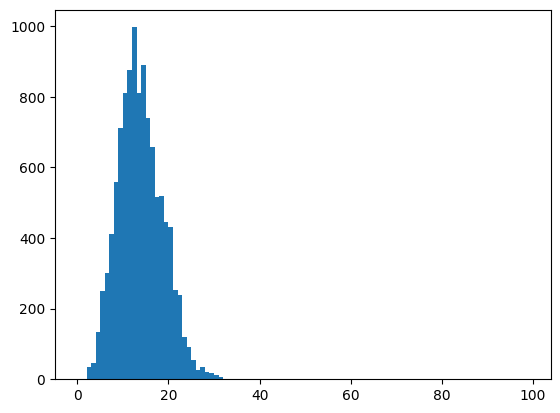

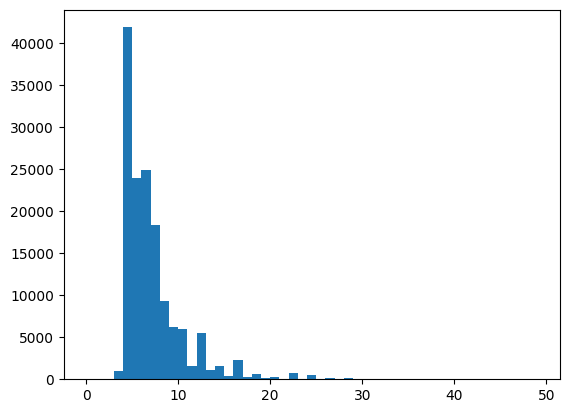

In [5]:
import os
import json
from glob import glob
from tqdm import tqdm
import numpy as np
import shutil

from matplotlib import pyplot as plt

_MAX_NUM_PANELS = 30
_MAX_NUM_EDGES = 40

# data_roots = ["\\\\192.168.29.222\\Share\\工程数据Q1\\objs", "\\\\192.168.29.222\\Share\\工程数据Q2_objs"]
# all_items = []
# for data_root in data_roots:
#     cur_items = glob(os.path.join(data_root, '**', 'pattern.json'), recursive=True)
#     all_items += cur_items
#     print("%d items in %s."%(len(cur_items), data_root))

num_panels = []
num_edges = []

invalid_items_dir = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\invalid_objs"
os.makedirs(invalid_items_dir, exist_ok=True)
    
invalid_other = []
invalid_wrong_panel_name = []
invalid_too_many_edges = []
invalid_too_many_panels = []
    
_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']
    
for data_fp in tqdm(all_items):
    try:
        is_valid = True
        
        with open(data_fp, 'r', encoding='utf-8') as f: pattern_spec = json.load(f)
        n_panels = len(pattern_spec['panels'])
        if n_panels > _MAX_NUM_PANELS:
            invalid_too_many_panels.append((data_fp, n_panels))
            print('[TOO_MANY_PANELS] %s: %d'%(data_fp, n_panels))
        
        num_panels.append(n_panels)
        for panel in pattern_spec['panels']:
            if panel['label'].strip().split()[0].split('_')[0] not in _PANEL_CLS:
                is_valid = False
                print('\t [WRONG_PANEL_LABEL] %s: %s - %s'%(data_fp, panel['id'], panel['label']))
            n_edges = sum([len(x['edges']) for x in panel['seqEdges'] if x['type'] == 3])
            if n_edges > _MAX_NUM_EDGES:
                invalid_too_many_edges.append((data_fp, panel['id'], n_edges))
                print('\t [TOO_MANY_EDGES] %s: %s - %d'%(data_fp, panel['id'], n_edges))
            num_edges.append(n_edges)
        
        if not is_valid: 
            invalid_wrong_panel_name.append(data_fp)
        
    except Exception as e:
        invalid_other.append(data_fp)
        print('Error in %s: %s'%(data_fp, e))
        continue
        
print(len(num_panels))
print(len(num_edges))
    
plt.hist(np.asarray(num_panels), bins=range(0, 100, 1))
plt.show()

plt.hist(np.asarray(num_edges), bins=range(0, 50, 1))
plt.show()

In [ ]:
plt.hist(np.asarray(num_panels), bins=range(0, 50, 1))
plt.show()

plt.hist(np.asarray(num_edges), bins=range(0, 50, 1))
plt.show()

In [10]:
print(len(invalid_too_many_edges))
print(len(set([x[0] for x in invalid_too_many_edges])))
for item in invalid_too_many_edges:
    print(item)

121
69
('\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0311\\阙志华\\宽松V领荷叶边百褶连衣裙\\pattern.json', 'd7a5df03-d1fc-416f-a62c-f8744252bf88', 116)
('\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0311\\阙志华\\宽松V领荷叶边百褶连衣裙\\pattern.json', '05aa40da-585b-4292-8c72-0a8a03dec3d0', 124)
('\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0311\\阙志华\\宽松V领荷叶边百褶连衣裙\\pattern.json', '8f20cbf6-aba0-4977-88a2-819eeadcf030', 124)
('\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0311\\阙志华\\宽松V领荷叶边百褶连衣裙\\pattern.json', '7a16660b-cde3-4d43-a16f-b46219df5742', 116)
('\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0314\\阙志华\\合体一片袖衬衫袖口A摆坦克线连衣裙\\pattern.json', 'd29b7bff-cf5e-45f0-b286-df40e57d9872', 54)
('\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0314\\阙志华\\合体一片袖衬衫袖口A摆坦克线连衣裙\\pattern.json', '5ab8df68-7a0a-432d-97f0-6abe34909277', 54)
('\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0314\\阙志华\\宽松圆领连身袖工字褶连衣裙\\pattern.json', '3488da70-e7b1-4b97-9255-f126582c6a33', 76)
('\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类

In [12]:
print(invalid_wrong_panel_name)

['\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0328\\张雪\\运动小翻领短袖H型运动连衣裙\\pattern.json', '\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\参考图+工程类\\0304\\林春秀\\修身宽领口插肩短袖侧开衩\\修身宽领口插肩短袖侧开衩\\pattern.json', '\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\参考图+工程类\\0304\\林春秀\\紧身后V领无袖侧抽褶长裙\\紧身后V领无袖侧抽褶长裙\\pattern.json', '\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\参考图+工程类\\0306\\林春秀\\A型V领荷叶泡泡袖短袖中长裙\\A型V领荷叶泡泡袖短袖中长裙\\pattern.json', '\\\\192.168.29.222\\Share\\工程数据Q2_objs\\仅工程类\\0422\\张雪\\立领叠门襟落肩拐袖拼腰节收腰腰上下抽褶下摆多层次短款宽松连衣裙\\pattern.json', '\\\\192.168.29.222\\Share\\工程数据Q2_objs\\仅工程类\\0422\\张雪\\罗纹圆领落肩拐袖收腰上腰抽褶下平下摆A型长款连衣裙\\pattern.json', '\\\\192.168.29.222\\Share\\工程数据Q2_objs\\仅工程类\\0422\\张雪\\衬衫领叠门襟落肩拐袖袖山袖口抽褶牛筋腰节左右不对称左抽牛筋右荷叶边收腰短款宽松连衣裙\\pattern.json', '\\\\192.168.29.222\\Share\\工程数据Q2_objs\\仅工程类\\0430\\张晓雯\\H型正常肩无袖无门襟袖窿公主线分割单向褶荷叶摆无领高垂领\\pattern.json', '\\\\192.168.29.222\\Share\\工程数据Q2_objs\\仅工程类\\0508\\肖晓珊\\H型1正常肩1-无袖1半开门襟1收腰省1抽皱腰节1拼接抽皱1有领-海军领2\\pattern.json', '\\\\192.168.29.222\\Share\\工程数据Q2_objs\\仅工程类\\0508\\肖晓珊